In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ARIMA
import pmdarima as pm
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('./data/ghana_gdp.csv',
                 index_col='year', parse_dates=['year'])

display(df.head())
display(df.info())


,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


None

<AxesSubplot: xlabel='year'>

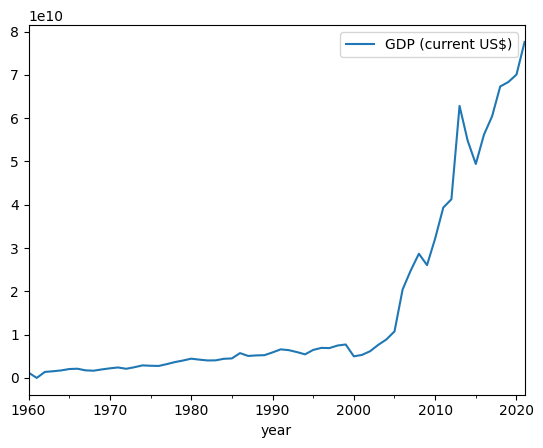

In [3]:
df.plot()

___
___

## Первичное моделирование

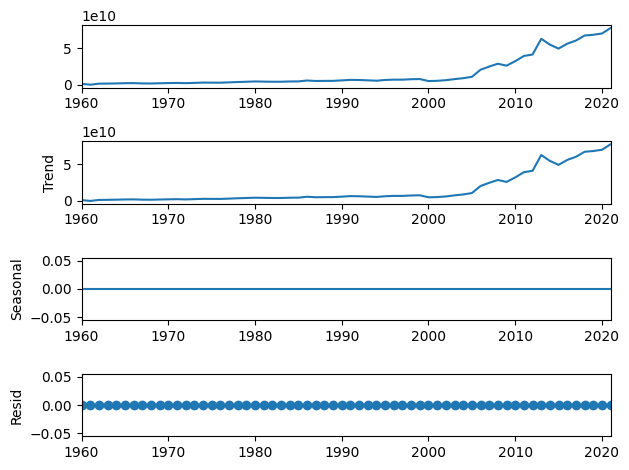

In [4]:
decompose = seasonal_decompose(df)
decompose.plot()
plt.show()


#### Наличие восходящего тренда, отсуствие сезонности, что говорит о вероятной нестационарности ряда.

---

Разделение выборки на тренировочную и тестовую выборки

In [5]:
train_df = df[:-3]
test_df = df[-3:]


---

### Модель скользящего среднего - base_line
Испоьзуем скользящее среднее для формирования базового предсказания

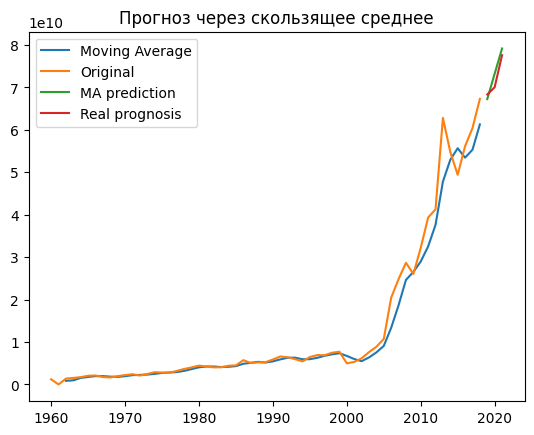

RMSE для прогноза MA: 2143290602.250167


In [6]:
# Moving average prediction
def ma_prediction(train_data, test_data=None, window_size=3, pred_num=3):

    data_ma = train_data.rolling(window_size).mean()
    last_values = data_ma.tail(window_size).values
    prediction = np.array([last_values[-1] +
                           (last_values[-1] - last_values[-2]) * i for i in range(1, pred_num + 1)])
    prediction = pd.DataFrame(
        prediction, columns=test_data.columns, index=test_data.index)
    return data_ma, prediction


ma_model, ma_pred = ma_prediction(train_df, test_df, window_size=3)
plt.plot(ma_model, label='Moving Average')
plt.plot(train_df, label='Original')
plt.plot(ma_pred, label='MA prediction')
plt.plot(test_df, label='Real prognosis')
plt.title('Прогноз через скользящее среднее')
plt.legend()
plt.show()
ma_rmse = np.sqrt(mean_squared_error(test_df, ma_pred))
print(f'RMSE для прогноза MA: {ma_rmse}')


In [7]:
data_ma = train_df.rolling(3).mean()
last_values = data_ma.tail(3).values
[last_values[-1] + (last_values[-1] - last_values[-2])
 * i for i in range(1, 4)]
[2*i for i in range(1, 3 + 1)]


[2, 4, 6]

#### Вывод: модель скользящего среднего достаточно точно предсказывает значения для тестового периода в случае окна скольжения равного 2-3.

---

### Проверка на стационарность

In [8]:
# Создадим функцмя для проверки ряда на стационарность
def stationary(data, p_value=0.05):
    stats = adfuller(data)
    if stats[1] > p_value:
        print('Ряд не стационарен')
    else:
        print('Ряд стационарен')


stationary(df)


Ряд не стационарен


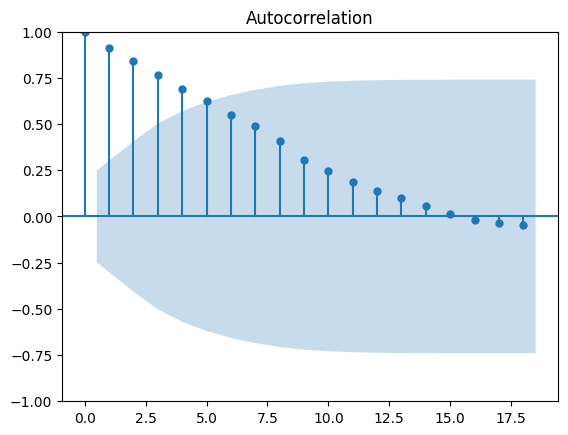

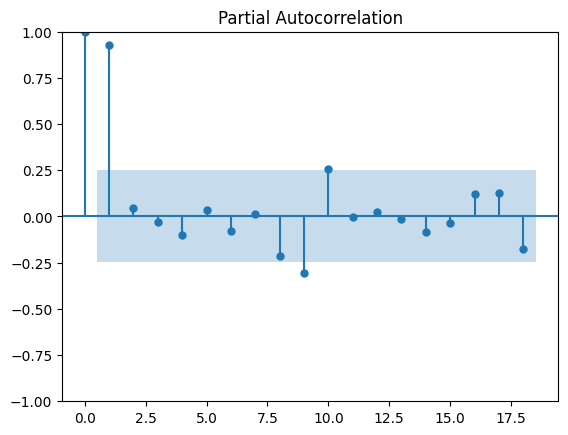

In [9]:
# Выведем графики полной и частичной автокорреляции исходного ряда
acf = plot_acf(df)
plt.show()
pacf = plot_pacf(df)
plt.show()


Вывод: ряд не стационарен для дальнейшей работы берем модель ARIMA (так как потребуется дифференцирование), так как отсутсвует сезонная компонента (SARIMA не понадобится) и нет внешних данных (для SARIMAX)

---

### Коррелограммы

Произведем диференцирование ряда 1 степени

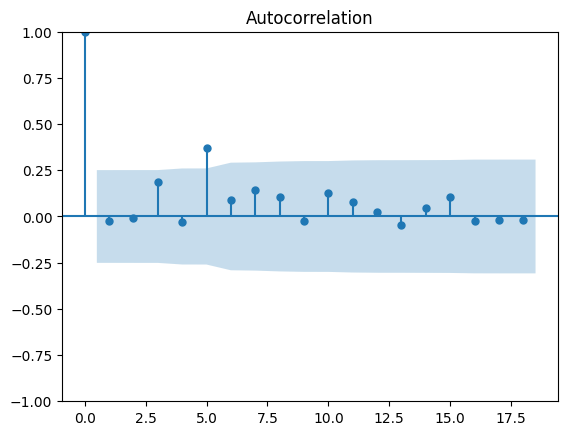

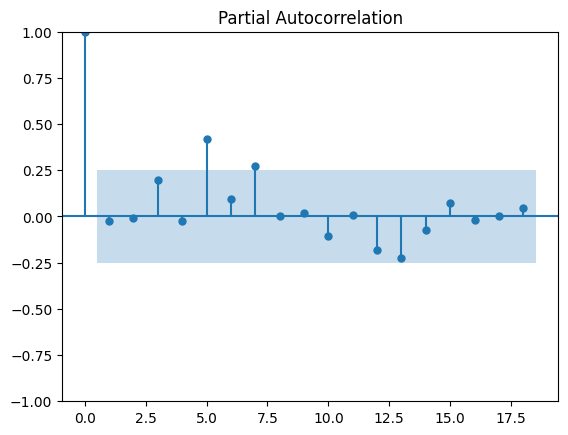

Ряд не стационарен


In [10]:
# Выведем графики для дифференцированного ряда 1 степени
acf = plot_acf(df_diff := df.diff().dropna())
plt.show()
pacf = plot_pacf(df_diff)
plt.show()

# Проведем проверку на стационарность
stationary(df_diff)

Произведем дифиринцирование 2 и 3 порядка

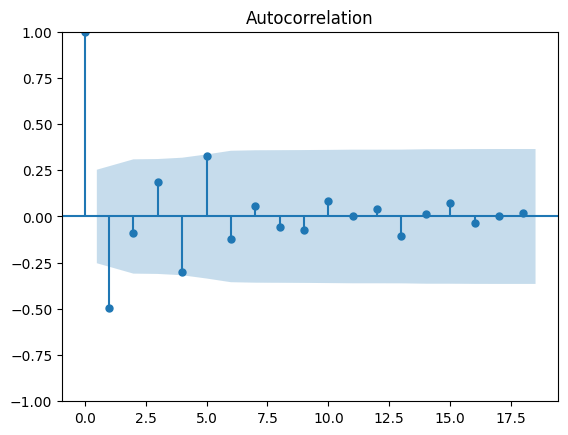

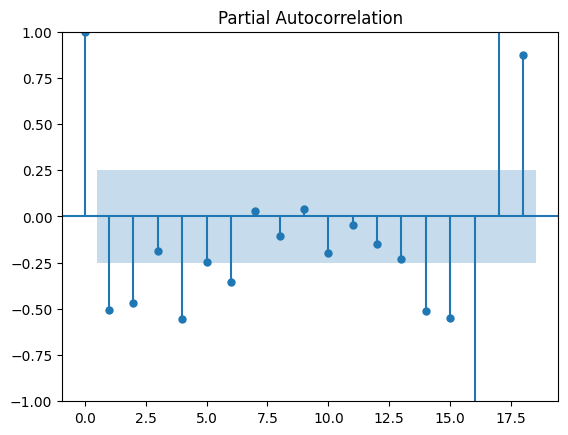

Ряд не стационарен


In [11]:
# Выведем графики для дифференцированного ряда 2 степени
acf = plot_acf(df_diff_2 := df_diff.diff().dropna())
plt.show()
pacf = plot_pacf(df_diff_2)
plt.show()

# Проведем проверку на стационарность
stationary(df_diff_2)


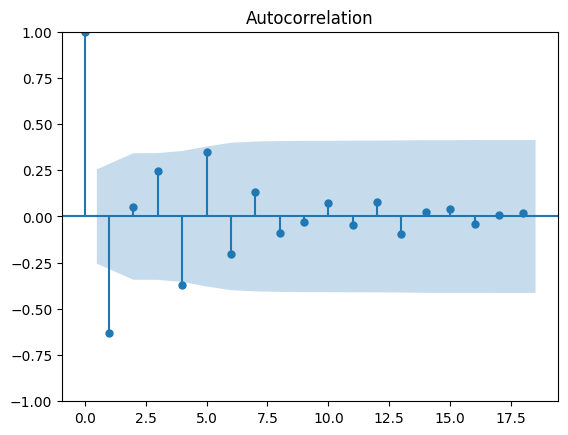

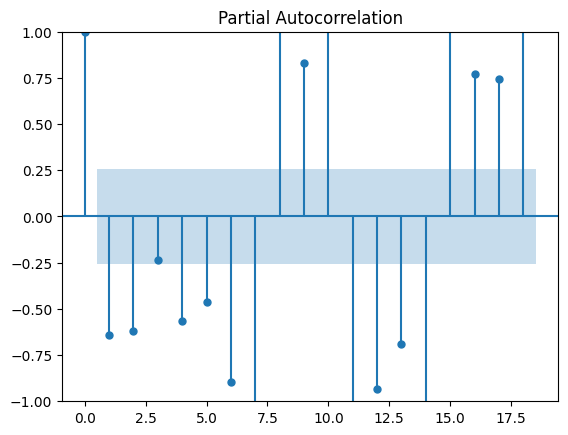

Ряд стационарен


In [12]:
# Выведем графики для дифференцированного ряда 3 степени
acf = plot_acf(df_diff_3 := df_diff_2.diff().dropna())
plt.show()
pacf = plot_pacf(df_diff_3)
plt.show()

# Проведем проверку на стационарность
stationary(df_diff_3)


На 3 этапе диференцирования мы получили стационарный ряд, это наше d для модели ARIMA

Параметры p и q мы берем из графиков корреляции для первоначального ряда

In [13]:
p = 1  # Определяется по коррелограмме частичной автокорреляции
q = 5  # Определяется по коррелограмме автокорреляции
d = 3# d найден ранее по тесту Дики-Фуллера, в нашем случае (не стационарного ряда) равен 1, т.к. пришлось дифференировать ряд 1 раз


In [14]:
arma_model = ARIMA(train_df.dropna(), order=(p, d, q))
arma_model_fit = arma_model.fit()
arma_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 5)   Log Likelihood               -1323.504
Date:                Mon, 07 Aug 2023   AIC                           2661.008
Time:                        17:36:43   BIC                           2675.186
Sample:                    01-01-1960   HQIC                          2666.505
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6181      0.810     -0.763      0.445      -2.206       0.970
ma.L1         -1.3372      1.100     -1.216      0.224      -3.492       0.818
ma.L2         -0.4579      1.997     -0.229      0.819      -4.372       3.456
ma.L3          1.3992      0.580      2.411      0.016       0.262       2.536
ma.L4         -0.3987      0.992     -0.402      0.688      -2.343       1.546
ma.L5         -0.1746      0.645     -0.271      0.787      -1.439       1.090
sigma2      3.616e+19   4.09e-20   8.85e+38      0.000    3.62e+19    3.62e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               104.94
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             174.69   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.38e+55. Standard errors may be unstable.
"""

In [15]:
# расчитываем предсказанные значения
pred_df = pd.DataFrame(index=test_df.index)

pred_df["GDP (model US$)"] = arma_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

# стоим доверительный интервал для предсказанных значений
forecast = arma_model_fit.get_forecast(len(test_df))
forecast_df = forecast.conf_int(alpha=0.05)  # это он и есть


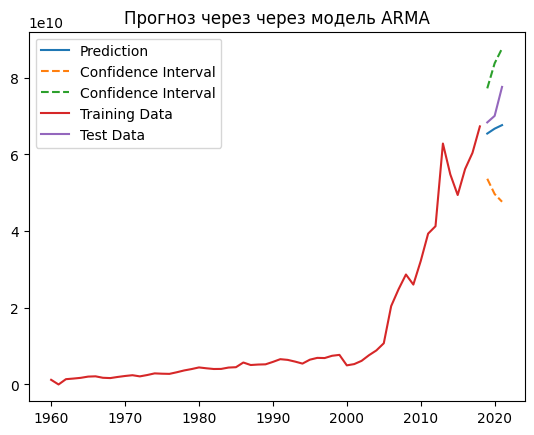

In [16]:
plt.plot(pred_df, label='Prediction')
plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
plt.plot(train_df, label='Training Data')
plt.plot(test_df, label='Test Data')
plt.title('Прогноз через через модель ARMA')
plt.legend()
plt.show()


In [17]:
arima_rmse = np.sqrt(mean_squared_error(test_df, pred_df))
print(f'RMSE для прогноза ARIMA: {arma_rmse}')


NameError: name 'arma_rmse' is not defined

In [ ]:
# Проверим RMSE моделей ARIMA и base-line
arima_rmse > ma_rmse


True

Модель авторегрессии на скользящем среднем показала худший результат нежели base-line MA, с достаточно широким доверительным интервалом

---

### Подбор параметров модели через pm.auto_arima

Проведем подбор параметров модели

In [ ]:
model_auto = pm.auto_arima(train_df)
forecast, conf_int = model_auto.predict(n_periods=3, return_conf_int=True)

auto_rmse = np.sqrt(mean_squared_error(test_df, forecast))
model_auto.arparams

<bound method ARIMA.arparams of ARIMA(order=(1, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>

In [ ]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 07 Aug 2023   AIC                           2680.765
Time:                        16:34:16   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.92e+55. Standard errors may be unstable.
"""

In [ ]:
conf_low = pd.DataFrame(conf_int.T[0], columns=[
                        'lower_bound'], index=test_df.index)
conf_high = pd.DataFrame(conf_int.T[1], columns=[
                         'upper_bound'], index=test_df.index)


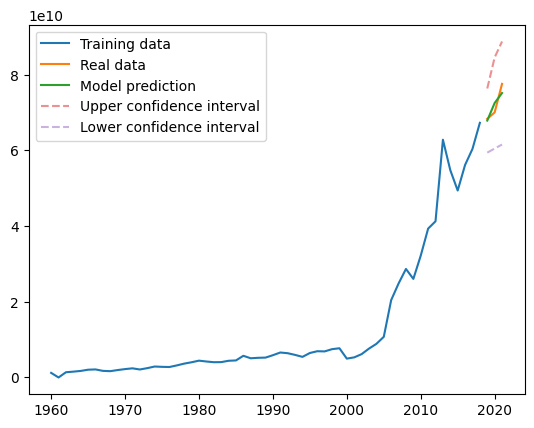

In [ ]:
plt.plot(train_df, label='Training data')
plt.plot(test_df, label='Real data')
plt.plot(forecast, label='Model prediction')
plt.plot(conf_high, linestyle="--",
         label='Upper confidence interval', alpha=0.5)
plt.plot(conf_low, linestyle="--", label='Lower confidence interval', alpha=0.5)
plt.legend()
plt.show()


In [ ]:
# Проверим RMSE моделей с автоматически подобранными параметрами и base-line
auto_rmse > ma_rmse


False

Вывод: алгоритм pm.auto_arima показал лучишй результат среди использованных подходов, а так же сформировал достаточно узкий доверительный интервал, при этом нужно отметить, что показатель AIC выше у ARIMA с подобранными в ручную параметрами.

---
---


## Интерполяция

Проверка нулевых значений

In [ ]:
df[df.asfreq(freq='AS') != 0].isna().sum()

GDP (current US$)    1
dtype: int64

Замена нулевых значений на Nan

In [ ]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

Интерполяция линейным методом

In [ ]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

Разделение на трейн/тест

In [ ]:
train_df = df[:-3]
test_df = df[-3:]


Проверка ряда на стационарность

In [ ]:
stationary(df)

Ряд не стационарен


In [ ]:
# Дифференциация 1 степени
stationary(df_diff_1:=df.diff().dropna())

Ряд не стационарен


In [ ]:
# Дифференциация 2 степени
stationary(df_diff_2:=df_diff_1.diff().dropna())

Ряд не стационарен


In [ ]:
# Дифференциация 3 степени
stationary(df_diff_3:=df_diff_2.diff().dropna())

Ряд стационарен


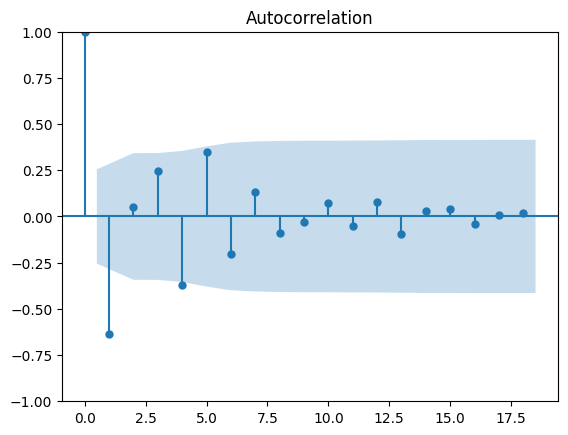

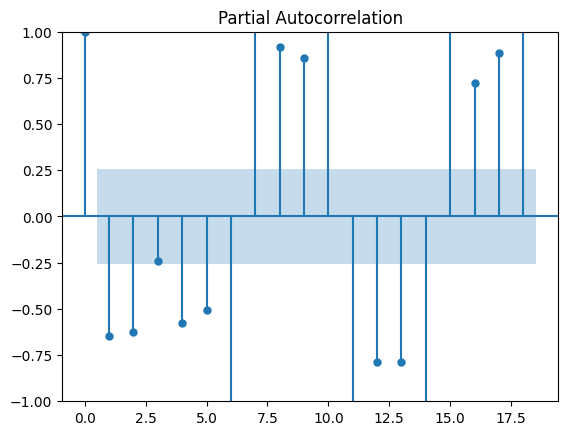

In [ ]:
acf = plot_acf(df_diff_3)
plt.show()
pacf = plot_pacf(df_diff_3)
plt.show()


In [ ]:
model_arima = ARIMA(train_df, order=(1, 2, 3))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 07 Aug 2023   AIC                           2680.513
Time:                        16:34:17   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.39e+54. Standard errors may be unstable.
"""

По сравнению с моделью построеной на подборе параметров pm_auto_arima (как модель показавшая наилучший результат прогнозирования), модель с интерполяцией с использованием наиболее оптимальных параметров показала статистически не значимый прирост показателя AIC, что обусловлено фактом наличия лишь одного нулевого значения во всем ряду.

___
___

### Проверка волатильности


In [ ]:
df['volatility'] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
train_df = df[:-3]
test_df = df[-3:]

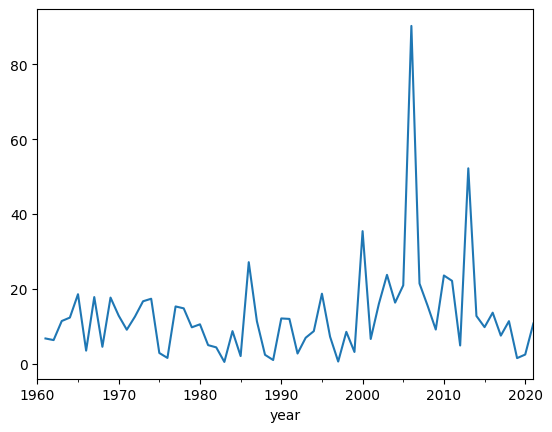

In [ ]:
# Визуализация волатильности
df['volatility'].plot()
plt.show()

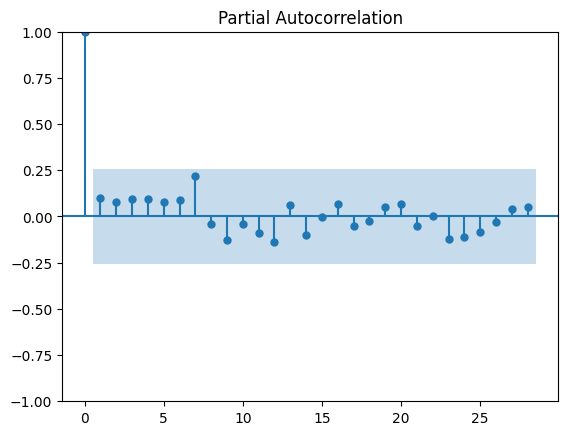

In [ ]:
# Визуализация частичной автокорреляции
plot_pacf(train_df['volatility'][1:], lags=28, method="ywm")
plt.show()

In [ ]:
# Проверим на стационарность
stationary(train_df['volatility'][1:])

Ряд стационарен


Наблюдается волатильность данных, ряд стационарен, исходя из графика частичной автокорреляции самый большой лаг равен 7

---

Используем модель GARCH

In [ ]:
# Создадим датафрейм 
garch_df = pd.DataFrame(df["volatility"].loc[df.index])
garch_df.loc[train_df.index, "volatility"] = train_df["volatility"].dropna()

model = arch_model(garch_df["volatility"].dropna(), p=7, q=7)
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61758881916293
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40872441098392
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.1004077963209
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01215123400175
Iteration:     30,   Func. Count:    523,   Neg. LLF: 214.1425883784412
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.0075011376221
            Iterations: 34
            Function evaluations: 577
            Gradient evaluations: 33


In [ ]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.015
Method:            Maximum Likelihood   BIC:                           492.982
                                        No. Observations:                   58
Date:                Mon, Aug 07 2023   Df Residuals:                       57
Time:                        16:34:17   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8596      1.563      7.586  3.307e-14 [  8.795, 14.924]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1822     41.757      1.058      0.290    [-37.661,1.260e+02]
alpha[1]   1.5748e-11  7.620e-02  2.067e-10      1.000      [ -0.149,  0.149]
alpha[2]   5.9045e-11  2.286e-02  2.583e-09      1.000 [-4.481e-02,4.481e-02]
alpha[3]   1.2799e-11  6.776e-02  1.889e-10      1.000      [ -0.133,  0.133]
alpha[4]   3.6012e-03  1.468e-02      0.245      0.806 [-2.518e-02,3.238e-02]
alpha[5]   1.2221e-11  1.262e-02  9.685e-10      1.000 [-2.473e-02,2.473e-02]
alpha[6]       0.7331      0.907      0.808      0.419      [ -1.045,  2.512]
alpha[7]       0.1024      0.633      0.162      0.871      [ -1.138,  1.343]
beta[1]    4.7722e-12      0.493  9.678e-12      1.000      [ -0.966,  0.966]
beta[2]    4.0394e-11  6.069e-02  6.656e-10      1.000      [ -0.119,  0.119]
beta[3]    4.4430e-11  2.835e-02  1.567e-09      1.000 [-5.557e-02,5.557e-02]
beta[4]    1.6154e-11  8.990e-02  1.797e-10      1.000      [ -0.176,  0.176]
beta[5]    9.3561e-12  5.234e-02  1.787e-10      1.000      [ -0.103,  0.103]
beta[6]    2.4230e-11  2.991e-02  8.102e-10      1.000 [-5.861e-02,5.861e-02]
beta[7]    3.5665e-12      1.135  3.143e-12      1.000      [ -2.224,  2.224]
=============================================================================

Covariance estimator: robust
"""

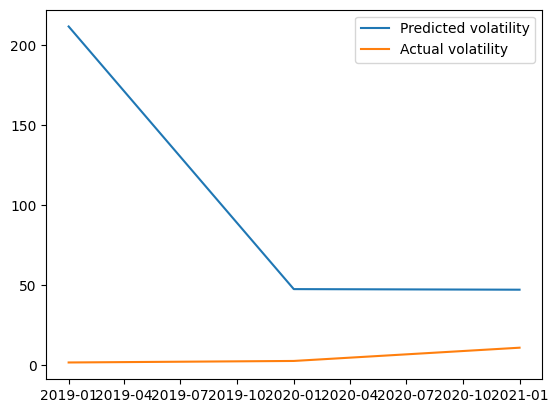

In [ ]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

plt.plot(predictions_df['Predictions'], label = 'Predicted volatility')
plt.plot(predictions_df['volatility'], label = 'Actual volatility')
plt.legend()

Вывод: модель плохо предсказала волатильность, возможная причина малое количество данных, а так же то, что в обучающих данных не было такого атипичного поведения.

---

---
---

### Валидация данных

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(df['GDP (current US$)']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7
